In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv("Dataset.csv")
tickers = df.groupby('Ticker')
dates = df.date.unique()
dates = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]

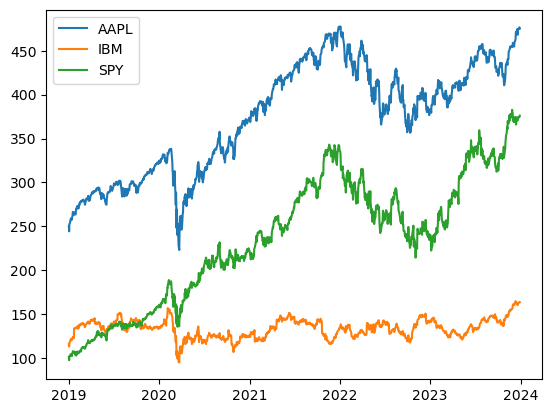

In [3]:
for name, data in tickers:
    plt.plot(dates, data.PRC.values, '-', label = name)
plt.legend()

In [4]:
def ts_split(ts, feature_steps=10, target_steps=1):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps].flatten() for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps][:, -1]
                  for idx in range(n_obs)])
    return X, y

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset and print columns
df = pd.read_csv("Dataset.csv")
print("Available columns:", df.columns.tolist())

# Group by 'Ticker'
tickers = df.groupby('Ticker')

def ts_split(ts, feature_steps=10, target_steps=1):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps][:, -1]
                  for idx in range(n_obs)])
    return X, y

# Initialize dictionaries
feature_steps = 10
target_steps = 1
X_train, y_train = {}, {}
X_test, y_test = {}, {}
X_valid, y_valid = {}, {}

for name, data in tickers:
    # Use only available columns (modify this based on printed columns)
    features = data[['VOL', 'BID', 'ASK', 'date']]  # Example columns
    target = data['PRC']
    
    # Convert dates
    dates = [dt.datetime.strptime(d, '%m/%d/%Y').date() for d in features['date']]
    min_date = min(dates)
    features.loc[:, 'date'] = [(d - min_date).days for d in dates]
    
    # Remove missing values
    valid_indices = ~features.isna().any(axis=1)
    features = features[valid_indices]
    target = target[valid_indices]
    
    if len(features) < feature_steps + target_steps:
        print(f"Not enough data for ticker {name}")
        continue
        
    # Prepare features and target
    X, y = ts_split(np.column_stack([features.values, target.values]), feature_steps, target_steps)
    
    # Split data
    train_size = int(len(X) * 0.8)
    valid_size = int(train_size * 0.8)
    
    X_train[name] = X[:valid_size]
    y_train[name] = y[:valid_size]
    X_valid[name] = X[valid_size:train_size]
    y_valid[name] = y[valid_size:train_size]
    X_test[name] = X[train_size:]
    y_test[name] = y[train_size:]

# Concatenate all data
X_train_all = np.concatenate(list(X_train.values()), axis=0)
y_train_all = np.concatenate(list(y_train.values()), axis=0)
X_valid_all = np.concatenate(list(X_valid.values()), axis=0)
y_valid_all = np.concatenate(list(y_valid.values()), axis=0)
X_test_all = np.concatenate(list(X_test.values()), axis=0)
y_test_all = np.concatenate(list(y_test.values()), axis=0)

print("Data shapes:")
print(f"X_train: {X_train_all.shape}")
print(f"X_valid: {X_valid_all.shape}")
print(f"X_test: {X_test_all.shape}")

Available columns: ['PERMNO', 'date', 'BIDLO', 'ASKHI', 'PRC', 'VOL', 'BID', 'ASK', 'NUMTRD', 'Ticker']
Data shapes:
X_train: (2394, 10, 5)
X_valid: (600, 10, 5)
X_test: (750, 10, 5)


In [12]:
print(X_train_all)

[[[1.26925200e+08 2.50250000e+02 2.50259995e+02 0.00000000e+00
   2.50179993e+02]
  [1.44140688e+08 2.44119995e+02 2.44130005e+02 1.00000000e+00
   2.44210007e+02]
  [1.42628832e+08 2.52449997e+02 2.52460007e+02 2.00000000e+00
   2.52389999e+02]
  ...
  [7.38581120e+07 2.58910004e+02 2.58920013e+02 9.00000000e+00
   2.58980011e+02]
  [7.09082240e+07 2.57450012e+02 2.57459991e+02 1.20000000e+01
   2.57399994e+02]
  [8.52082720e+07 2.60369995e+02 2.60380005e+02 1.30000000e+01
   2.60350006e+02]]

 [[1.44140688e+08 2.44119995e+02 2.44130005e+02 1.00000000e+00
   2.44210007e+02]
  [1.42628832e+08 2.52449997e+02 2.52460007e+02 2.00000000e+00
   2.52389999e+02]
  [1.03139104e+08 2.54279999e+02 2.54289993e+02 5.00000000e+00
   2.54380005e+02]
  ...
  [7.09082240e+07 2.57450012e+02 2.57459991e+02 1.20000000e+01
   2.57399994e+02]
  [8.52082720e+07 2.60369995e+02 2.60380005e+02 1.30000000e+01
   2.60350006e+02]
  [7.76367120e+07 2.60950012e+02 2.60959991e+02 1.40000000e+01
   2.60980011e+02]]



In [17]:
namelist = df['Ticker'].unique().tolist()
namelist

['SPY', 'IBM', 'AAPL']

In [19]:
X_train[namelist[0]]

array([[[35347045, 101.12, 101.13, 0, 101.12],
        [42570779, 97.35, 97.38, 1, 97.4],
        [44032862, 101.93, 101.94, 2, 101.93],
        ...,
        [28277502, 102.76, 102.78, 9, 102.8],
        [28416379, 102.04, 102.06, 12, 102.05],
        [31572516, 105.0, 105.02, 13, 105.01]],

       [[42570779, 97.35, 97.38, 1, 97.4],
        [44032862, 101.93, 101.94, 2, 101.93],
        [35650303, 102.04, 102.06, 5, 102.06],
        ...,
        [28416379, 102.04, 102.06, 12, 102.05],
        [31572516, 105.0, 105.02, 13, 105.01],
        [29843819, 105.37, 105.38, 14, 105.38]],

       [[44032862, 101.93, 101.94, 2, 101.93],
        [35650303, 102.04, 102.06, 5, 102.06],
        [31531077, 102.81, 102.82, 6, 102.8],
        ...,
        [31572516, 105.0, 105.02, 13, 105.01],
        [29843819, 105.37, 105.38, 14, 105.38],
        [28385667, 106.14, 106.16, 15, 106.12]],

       ...,

       [[28814144, 299.03, 299.13, 1153, 298.79001],
        [31320281, 294.95001, 295.01001, 1154, 2

In [34]:
import tensorflow as tf

class StopWhenValLossBelow(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(StopWhenValLossBelow, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.threshold:
            print(f"\nValidation loss below {self.threshold}. Stopping training...")
            self.model.stop_training = True


In [50]:
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Calculate the correct shape for reshaping
"""
num_samples_train = X_train_all.shape[0]
num_samples_valid = X_valid_all.shape[0]
feature_steps = X_train_all.shape[1]
num_features = X_train_all.shape[2] if len(X_train_all.shape) > 2 else 1
"""

# Build improved model
model = Sequential([
    Bidirectional(SimpleRNN(128, return_sequences=True), input_shape=(feature_steps, num_features)),
    BatchNormalization(),
    Dropout(0.3),
    
    #Bidirectional(SimpleRNN(128, return_sequences=True)),
    #BatchNormalization(),
    #Dropout(0.3),
    
    Bidirectional(SimpleRNN(64)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    #BatchNormalization(),
    
    Dense(1)
])



# Compile with reduced learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-9
)

# Calculate the correct shape for reshaping
"""
num_samples_train = X_train_all.shape[0]
num_samples_valid = X_valid_all.shape[0]
feature_steps = X_train_all.shape[1]
num_features = X_train_all.shape[2] if len(X_train_all.shape) > 2 else 1
"""
num_samples_train = X_train[namelist[0]].shape[0]
num_samples_valid = X_valid[namelist[0]].shape[0]
feature_steps = X_train[namelist[0]].shape[1]
num_features = X_train[namelist[0]].shape[2] if len(X_train_all.shape) > 2 else 1
# Ensure the data is in the correct format
"""
X_train_all = X_train_all.astype('float32')
y_train_all = y_train_all.astype('float32')
X_valid_all = X_valid_all.astype('float32')
y_valid_all = y_valid_all.astype('float32')
"""
X_train_SPY = X_train[namelist[0]].astype('float32')
y_train_SPY = y_train[namelist[0]].astype('float32')
X_valid_SPY = X_valid[namelist[0]].astype('float32')
y_valid_SPY = y_valid[namelist[0]].astype('float32')
# Reshape the input data to have the correct feature dimension
"""
X_train_all_reshaped = X_train_all.reshape((num_samples_train, feature_steps, num_features))
X_valid_all_reshaped = X_valid_all.reshape((num_samples_valid, feature_steps, num_features))
"""
X_train_SPY_reshaped = X_train_SPY.reshape((num_samples_train, feature_steps, num_features))
X_valid_SPY_reshaped = X_valid_SPY.reshape((num_samples_valid, feature_steps, num_features))

# Train model
stop_when_val_loss_below = StopWhenValLossBelow(threshold=2000)
history = model.fit(
    X_train_SPY_reshaped, 
    y_train_SPY,
    validation_data=(X_valid_SPY_reshaped, y_valid_SPY),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, stop_when_val_loss_below],
    verbose=1
)

Epoch 1/100
25/25 [==============================] - 4s 34ms/step - loss: 47516.8672 - val_loss: 68672.0938 - lr: 0.0010
Epoch 2/100
25/25 [==============================] - 0s 17ms/step - loss: 47506.5078 - val_loss: 68643.4531 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - 0s 18ms/step - loss: 47496.1914 - val_loss: 68597.9844 - lr: 0.0010
Epoch 4/100
25/25 [==============================] - 0s 18ms/step - loss: 47485.8047 - val_loss: 68542.5625 - lr: 0.0010
Epoch 5/100
25/25 [==============================] - 0s 18ms/step - loss: 47475.4570 - val_loss: 68475.1328 - lr: 0.0010
Epoch 6/100
25/25 [==============================] - 0s 18ms/step - loss: 47465.1172 - val_loss: 68393.8672 - lr: 0.0010
Epoch 7/100
25/25 [==============================] - 0s 19ms/step - loss: 47454.7773 - val_loss: 68292.8984 - lr: 0.0010
Epoch 8/100
25/25 [==============================] - 0s 18ms/step - loss: 47444.4258 - val_loss: 68191.2969 - lr: 0.0010
Epoch 9/100
25/25 [=============

In [48]:
# 遍历模型中的所有层，打印每一层的权重和偏置
for layer in model.layers:
    weights = layer.get_weights()  # 返回的是一个包含权重和偏置的列表
    if weights:  # 有些层（如 Dropout 层）没有权重或偏置
        print(f"Layer: {layer.name}")
        for i, w in enumerate(weights):
            print(f"  Weights {i}: {w.shape}")
            print(w)


Layer: bidirectional_59
  Weights 0: (5, 128)
[[ 5.12998164e-01 -1.99403450e-01  2.70780236e-01 -4.29395251e-02
  -6.32223338e-02 -2.79613078e-01 -8.99517894e-01  8.77956986e-01
  -1.06114471e+00 -3.87780339e-01 -4.57303107e-01 -3.33956122e-01
  -8.35216343e-01 -2.83692956e-01  4.52200443e-01 -3.28529149e-01
   3.45908612e-01  4.36997175e-01 -9.26347747e-02 -2.10472509e-01
  -1.83027282e-01  2.64459010e-02  1.17594850e+00 -1.02382052e+00
   4.71973233e-02 -1.42642725e+00 -6.15866482e-01  3.92825663e-01
  -4.62279648e-01  1.18796241e+00 -9.08843875e-01 -2.75985271e-01
   5.97952247e-01  4.23369259e-02 -5.58448434e-01 -3.43193620e-01
   6.64124668e-01 -1.28618670e+00 -2.90968001e-01 -1.08232903e+00
   4.16082859e-01 -7.75344789e-01  2.62956589e-01  8.63924980e-01
  -3.21931601e-01  9.23048079e-01 -1.29051521e-01  6.09042764e-01
   3.67239445e-01 -5.07558763e-01 -1.40353620e-01  6.13255262e-01
   6.34490311e-01 -2.06399381e-01 -3.98156017e-01 -7.20175326e-01
   1.25242436e+00 -5.67232430e

AttributeError: 'Sequential' object has no attribute 'parameters'

In [ ]:
"""
from tensorflow.keras.callbacks import EarlyStopping

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Ensure the data is in the correct format
X_train_all = X_train_all.astype('float32')
y_train_all = y_train_all.astype('float32')
X_valid_all = X_valid_all.astype('float32')
y_valid_all = y_valid_all.astype('float32')

# Train the model
history = model.fit(X_train_all, y_train_all, epochs=100, batch_size=32, validation_data=(X_valid_all, y_valid_all), callbacks=[early_stopping])
"""

Epoch 1/100
75/75 [==============================] - 6s 18ms/step - loss: 61339.1289 - val_loss: 76777.8828
Epoch 2/100
75/75 [==============================] - 1s 9ms/step - loss: 58988.2305 - val_loss: 74724.7344
Epoch 3/100
75/75 [==============================] - 1s 8ms/step - loss: 57250.0391 - val_loss: 72776.0703
Epoch 4/100
75/75 [==============================] - 1s 7ms/step - loss: 55634.3516 - val_loss: 70923.7734
Epoch 5/100
75/75 [==============================] - 1s 7ms/step - loss: 54063.1484 - val_loss: 69119.0156
Epoch 6/100
75/75 [==============================] - 1s 7ms/step - loss: 52567.5938 - val_loss: 67365.4141
Epoch 7/100
75/75 [==============================] - 1s 8ms/step - loss: 51078.3594 - val_loss: 65671.1719
Epoch 8/100
75/75 [==============================] - 0s 6ms/step - loss: 49643.9648 - val_loss: 64019.0469
Epoch 9/100
75/75 [==============================] - 1s 7ms/step - loss: 48271.0977 - val_loss: 62394.1250
Epoch 10/100
75/75 [================

Evaluating for ticker: AAPL
8/8 [==============================] - 0s 6ms/step - loss: 180800.4844
Model Loss for AAPL: 180800.484375
8/8 [==============================] - 0s 5ms/step


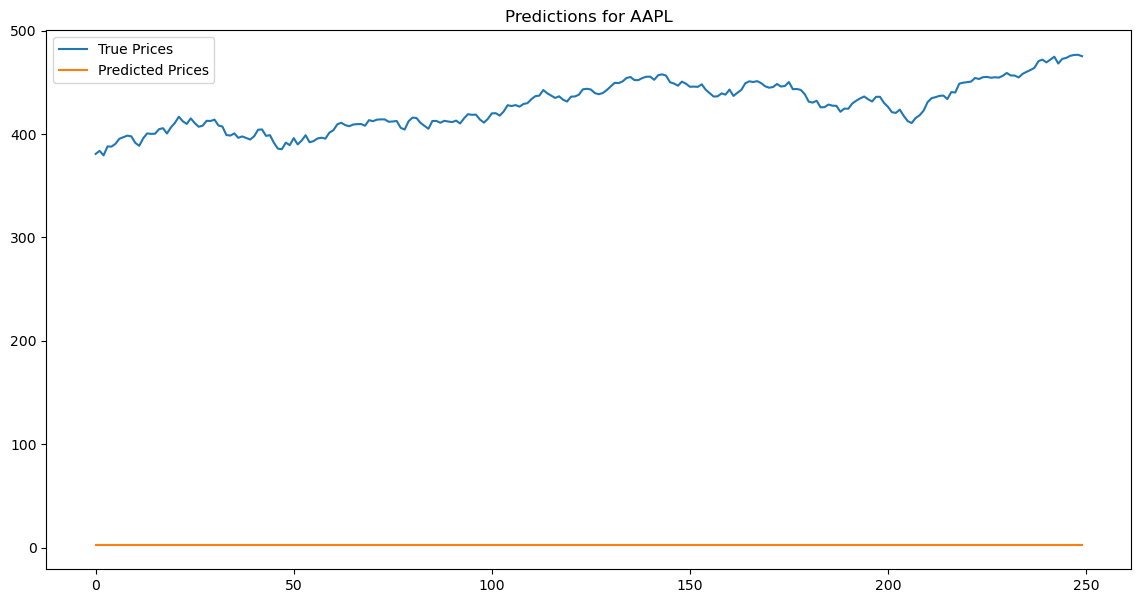

Evaluating for ticker: IBM
8/8 [==============================] - 0s 6ms/step - loss: 18701.4805
Model Loss for IBM: 18701.48046875
8/8 [==============================] - 0s 5ms/step


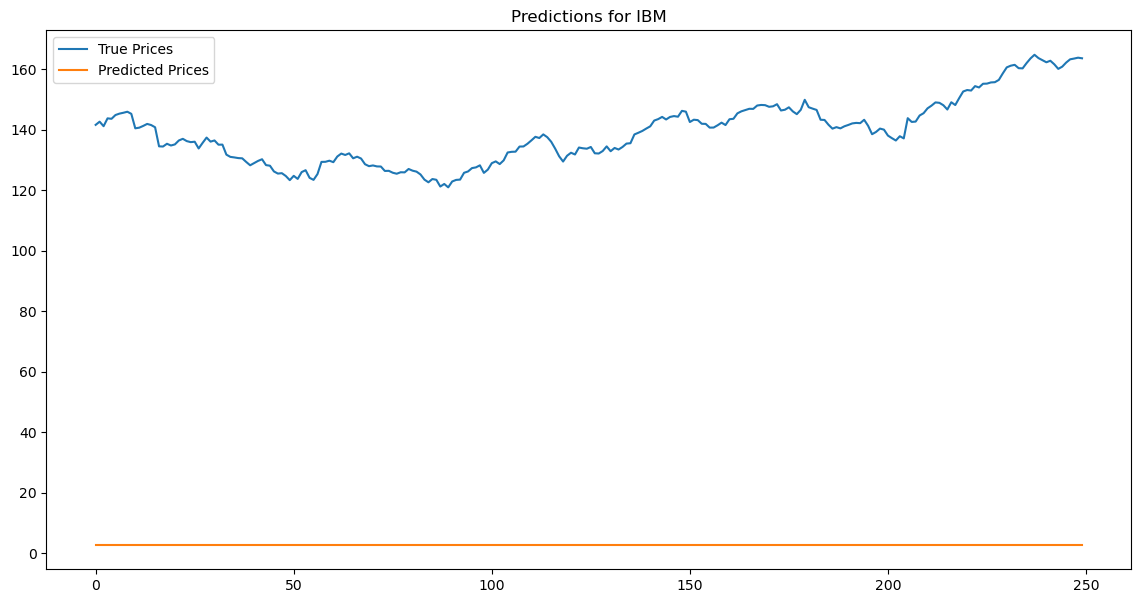

Evaluating for ticker: SPY
8/8 [==============================] - 0s 6ms/step - loss: 98498.2969
Model Loss for SPY: 98498.296875
8/8 [==============================] - 0s 5ms/step


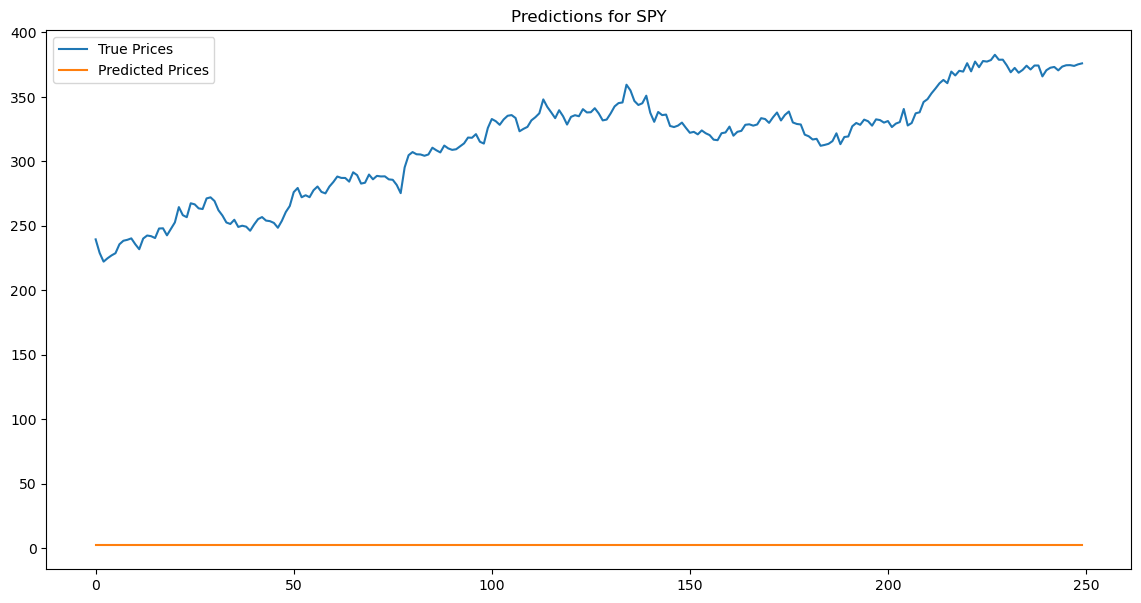

In [51]:
# Evaluate and predict for each ticker
for name in tickers.groups.keys():
    if name in X_test and name in y_test:
        print(f"Evaluating for ticker: {name}")
        
        # Ensure the data is in the correct format
        X_test[name] = X_test[name].astype('float32')
        y_test[name] = y_test[name].astype('float32')
        
        # Evaluate the model on the test set for the current ticker
        loss = model.evaluate(X_test[name], y_test[name])
        print(f'Model Loss for {name}: {loss}')

        # Make predictions on the test set for the current ticker
        predictions = model.predict(X_test[name])

        # Plot the predictions
        plt.figure(figsize=(14, 7))
        plt.plot(y_test[name], label='True Prices')
        plt.plot(predictions, label='Predicted Prices')
        plt.title(f'Predictions for {name}')
        plt.legend()
        plt.show()

In [13]:
print(tickers.groups.keys())

dict_keys(['AAPL', 'IBM', 'SPY'])


In [14]:
print(X_test)
print(y_test)

{'AAPL': array([[[1.19857952e+08, 3.83290009e+02, 3.83299988e+02, 1.44400000e+03,
         3.83269989e+02],
        [7.98781040e+07, 3.79980011e+02, 3.79989990e+02, 1.44700000e+03,
         3.80019989e+02],
        [7.44272400e+07, 3.80510010e+02, 3.80519989e+02, 1.44800000e+03,
         3.80540009e+02],
        ...,
        [7.09115200e+07, 3.76670013e+02, 3.76679993e+02, 1.45600000e+03,
         3.76660004e+02],
        [6.69708760e+07, 3.83380005e+02, 3.83390015e+02, 1.45700000e+03,
         3.83440002e+02],
        [8.40222080e+07, 3.82429993e+02, 3.82440002e+02, 1.45800000e+03,
         3.82429993e+02]],

       [[7.98781040e+07, 3.79980011e+02, 3.79989990e+02, 1.44700000e+03,
         3.80019989e+02],
        [7.44272400e+07, 3.80510010e+02, 3.80519989e+02, 1.44800000e+03,
         3.80540009e+02],
        [7.81673680e+07, 3.86220001e+02, 3.86230011e+02, 1.44900000e+03,
         3.86230011e+02],
        ...,
        [6.69708760e+07, 3.83380005e+02, 3.83390015e+02, 1.45700000e+03,